# Level-2 Soil Moisture (SM) algorithm performance assessment

This notebook implements a performance assessment of a prototype Level-2 Soil Moisture algorithm for CIMR. The assessment is based on a synthetic soil moisture test card, which is described in the algorithm implementation notebook. Only soil moisture retrievals are assessed, since soil moisture is the target variable of the algorithm.

Two performance metrics are considered: The unbiased RMSE (ubRMSE) and bias. The metrics are calculated for four AOIs that represent distinct land use and vegetation cover conditions. Soil moisture retrievals are assessed at the 36 km scale (L-band only) and at the 9 km scale (L-band sharpened with C-band).

## 1. Load the L2 datasets and reference data

In [46]:
# imports
from importlib import reload
import sys
import os
import numpy as np
import xarray as xr
import pyresample as pr
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from pyresample import parse_area_file

# define dirs
basedir, algodir = os.path.split(os.path.abspath(''))
algopath = os.path.join(basedir, algodir, 'sm_algo')
toolpath = os.path.join(basedir, algodir, 'tools')
datapath = os.path.join(basedir, 'data')

# add dirs to sys
if algopath not in sys.path:
    sys.path.insert(0, algopath)
if toolpath not in sys.path:
    sys.path.insert(0, toolpath)
    
# import DEVALGO SM module
import sm_algo.sm_evaluation as sm_eval
import sm_algo.sm_resampling as resample


### 1.1. Load the L2 Files

A total of eight L2 files are loaded, corresponding to four independent CIMR L2 retrievals at the 36 km and 9 km scales, respectively. 

In [47]:
# 36 km
l2_36_deimos_asc = xr.open_dataset(os.path.join(datapath, 'L2', 'cimr_devalgo_l2_sm_global-ease2-360_deimos_asc.nc'))
l2_36_deimos_des = xr.open_dataset(os.path.join(datapath, 'L2', 'cimr_devalgo_l2_sm_global-ease2-360_deimos_des.nc'))
l2_36_sceps_asc = xr.open_dataset(os.path.join(datapath, 'L2', 'cimr_devalgo_l2_sm_global-ease2-360_sceps_asc.nc'))
l2_36_sceps_des = xr.open_dataset(os.path.join(datapath, 'L2', 'cimr_devalgo_l2_sm_global-ease2-360_sceps_des.nc'))

# 9 km
l2_09_deimos_asc = xr.open_dataset(os.path.join(datapath, 'L2', 'cimr_devalgo_l2_sm_global-ease2-090_deimos_asc.nc'))
l2_09_deimos_des = xr.open_dataset(os.path.join(datapath, 'L2', 'cimr_devalgo_l2_sm_global-ease2-090_deimos_des.nc'))
l2_09_sceps_asc = xr.open_dataset(os.path.join(datapath, 'L2', 'cimr_devalgo_l2_sm_global-ease2-090_sceps_asc.nc'))
l2_09_sceps_des = xr.open_dataset(os.path.join(datapath, 'L2', 'cimr_devalgo_l2_sm_global-ease2-090_sceps_des.nc'))


### 1.2. Load the test card as reference

We load the test card and aggregate the soil moisture reference to the 36 km and 9 km global EASE2 grids. 

In [48]:
# Import soil moisture Testcard
file_testcard = 'DEVALGO_testcard_soil_moisture_coastlines.nc'
testcard = xr.open_dataset(os.path.join(datapath, 'TC', file_testcard))

# initialize
tc_36 = {}
tc_09 = {}

# compute dominant land use (lu) and water fraction (wf) at 36 km and 9 km resolutions
tc_36['lu'], tc_36['wf'] = resample.testcard_compute_lu_wf(testcard['Land Use'].data, 36)
tc_09['lu'], tc_09['wf'] = resample.testcard_compute_lu_wf(testcard['Land Use'].data, 9)
# average Soil Moisture and L-band TBs at 36 km and 9 km (used later for comparison and plotting)
tc_36['Soil Moisture'] = testcard['Soil Moisture'].coarsen(dim={'n_row': 36, 'n_col': 36}, boundary='trim').mean().data
tc_09['Soil Moisture'] = testcard['Soil Moisture'].coarsen(dim={'n_row': 9, 'n_col': 9}, boundary='trim').mean().data
# set values over water to nan
tc_36['Soil Moisture'][tc_36['lu'] == 5] = np.nan                                 
tc_09['Soil Moisture'][tc_09['lu'] == 5] = np.nan                              
tc_36['Soil Moisture'][tc_36['wf'] > 0.5] = np.nan                             
tc_09['Soil Moisture'][tc_09['wf'] > 0.5] = np.nan                         


## 2. Evaluation

### 2.1. Soil moisture retrievals at the 36 km grid

We show the soil moisture retrievals and errors (error = reference - retrieval) at the 36 km grid. We find that
- Errors within the AOIs (black boxes) are generally low, indicating that soil moisture patterns are captured across different land use classes.
- The largest errors occur at coastlines, which is expected due to waterbody contamination.
- Biases occur for forest regions, which is expected given the dense vegetation.
- The results are consistent across overpasses.
- DEIMOS scenes show edge effects, which is related to sharp boundaries in the L1B files and not related to the algorithm or processing.
- SCEPS scenes show effects of instrument noise (not considered in DEIMOS), which is particularly visible for forest retrievals.

An assessment of ubRMSE and bias metrics for the four AOIs is given in section 2.4.

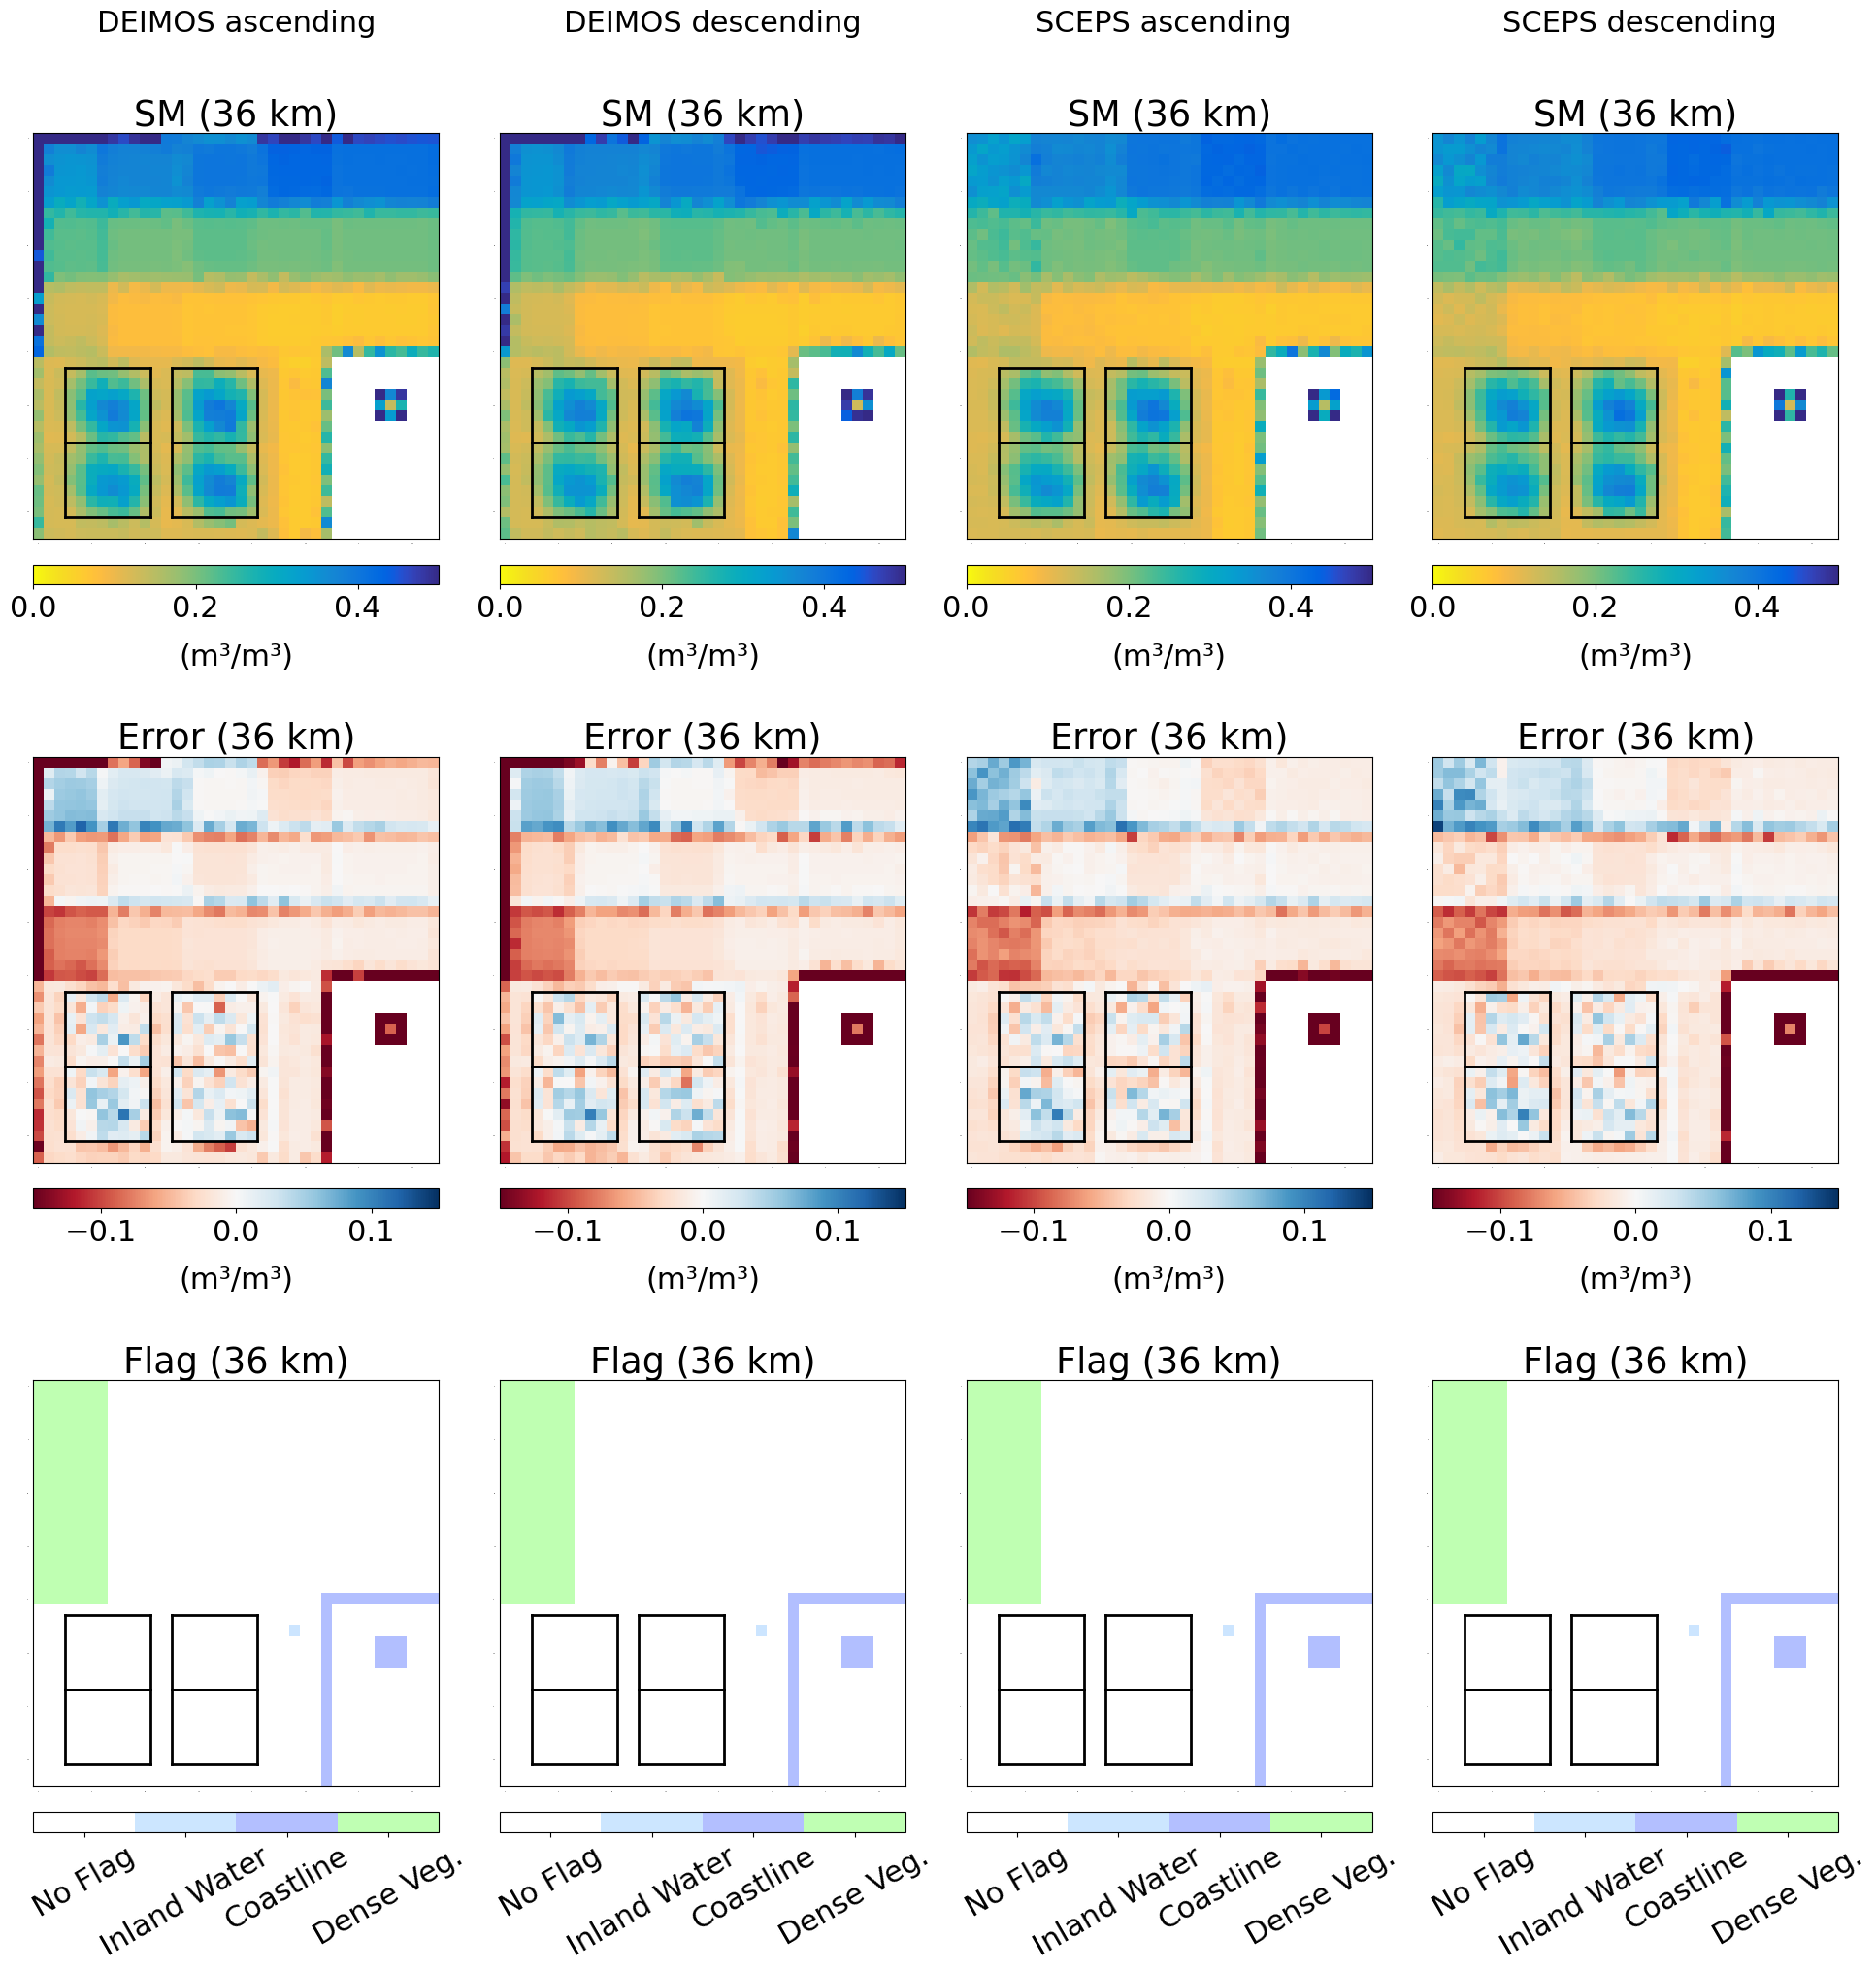

In [49]:
reload(sm_eval)

# Settings and colormaps
cmap_flags = matplotlib.colors.ListedColormap([[1, 1, 1], [0.9, 0.95, 1], [0.8, 0.85, 1], [0.85, 1, 0.8]])
leg_flag = ['No Flag', 'Water Fract', 'Coastline', 'Vegetation']
filenames = ['DEIMOS ascending', 'DEIMOS descending', 'SCEPS ascending', 'SCEPS descending']

# 36 km
xdist = -0.5
ydist = -0.85
reference = tc_36['Soil Moisture']
deimos_asc = l2_36_deimos_asc
deimos_des = l2_36_deimos_des
sceps_asc = l2_36_sceps_asc
sceps_des = l2_36_sceps_des
plot_range = [0.0, 0.5]
plot_range_diff = [-0.15, 0.15]
plt_range_flags = [0, 4]
grid = 36


# Plot
gs = gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1, 1])
fig = plt.figure(figsize=(6*4, 8*4))
# SM
ax = fig.add_subplot(gs[0, 0])
sm_eval.plot_sm(deimos_asc['soil_moisture'].data[0, :, :], 'SM (36 km)', grid, plot_range, None)
plt.text(5.5, -10, filenames[0])
ax = fig.add_subplot(gs[0, 1])
sm_eval.plot_sm(deimos_des['soil_moisture'].data[0, :, :], 'SM (36 km)', grid, plot_range, None)
plt.text(5.5, -10, filenames[1])
ax = fig.add_subplot(gs[0, 2])
sm_eval.plot_sm(sceps_asc['soil_moisture'].data[0, :, :], 'SM (36 km)', grid, plot_range, None)
plt.text(6, -10, filenames[2])
ax = fig.add_subplot(gs[0, 3])
sm_eval.plot_sm(sceps_des['soil_moisture'].data[0, :, :], 'SM (36 km)', grid, plot_range, None)
plt.text(6, -10, filenames[3])
# DELTA
ax = fig.add_subplot(gs[1, 0])
sm_eval.plot_sm_diff(reference, deimos_asc['soil_moisture'].data[0, :, :], 'Error (36 km)', grid, plot_range_diff, 'RdBu')
ax = fig.add_subplot(gs[1, 1])
sm_eval.plot_sm_diff(reference, deimos_des['soil_moisture'].data[0, :, :], 'Error (36 km)', grid, plot_range_diff, 'RdBu')
ax = fig.add_subplot(gs[1, 2])
sm_eval.plot_sm_diff(reference, sceps_asc['soil_moisture'].data[0, :, :], 'Error (36 km)', grid, plot_range_diff, 'RdBu')
ax = fig.add_subplot(gs[1, 3])
sm_eval.plot_sm_diff(reference, sceps_des['soil_moisture'].data[0, :, :], 'Error (36 km)', grid, plot_range_diff, 'RdBu')
# Flags
ax = fig.add_subplot(gs[2, 0])
sm_eval.plot_flag(deimos_asc['retrieval_scene_flag'].data[0, :, :], deimos_asc['retrieval_status_flag'].data[0, :, :], 'Flag (36 km)', grid)
ax = fig.add_subplot(gs[2, 1])
sm_eval.plot_flag(deimos_des['retrieval_scene_flag'].data[0, :, :], deimos_des['retrieval_status_flag'].data[0, :, :], 'Flag (36 km)', grid)
ax = fig.add_subplot(gs[2, 2])
sm_eval.plot_flag(sceps_asc['retrieval_scene_flag'].data[0, :, :], sceps_asc['retrieval_status_flag'].data[0, :, :], 'Flag (36 km)', grid)
ax = fig.add_subplot(gs[2, 3])
sm_eval.plot_flag(sceps_des['retrieval_scene_flag'].data[0, :, :], sceps_des['retrieval_status_flag'].data[0, :, :], 'Flag (36 km)', grid)
# adjust
plt.subplots_adjust(wspace=0.15, hspace=0.2)


### 2.2. Soil moisture retrievals at the 9 km grid

We show soil moisture retrievals and errors (error = reference - retrieval) at the 9 km grid. We find similar results compared to the 36 km retrievals. Results that are unique to 9 km retrievals are printed bold. 
- Errors within the AOIs (black boxes) are generally low, indicating that soil moisture patterns are captured across different land use classes. **The 9 km retrievals are evaluated against 9 km soil moisture patterns, such that additional error patterns are visible compared to 36 km retrievals. A more detailed view of these patterns is given in section 2.3.**
- The largest errors occur at coastlines, which is expected due to waterbody contamination.
- Biases occur for forest regions, which is expected given the dense vegetation.
- The results are consistent across overpasses.
- **Edge effects are visible in the northeastern area of the test card, which is an artifact resulting from the sharp land cover transitions in the synthetic test card.**
- DEIMOS scenes show edge effects, which is related to sharp boundaries in the L1B files and not related to the algorithm or processing.
- SCEPS scenes show effects of instrument noise (not considered in DEIMOS), which is particularly visible for forest retrievals.

An assessment of ubRMSE and bias metrics for the AOIs is given in section 2.4.

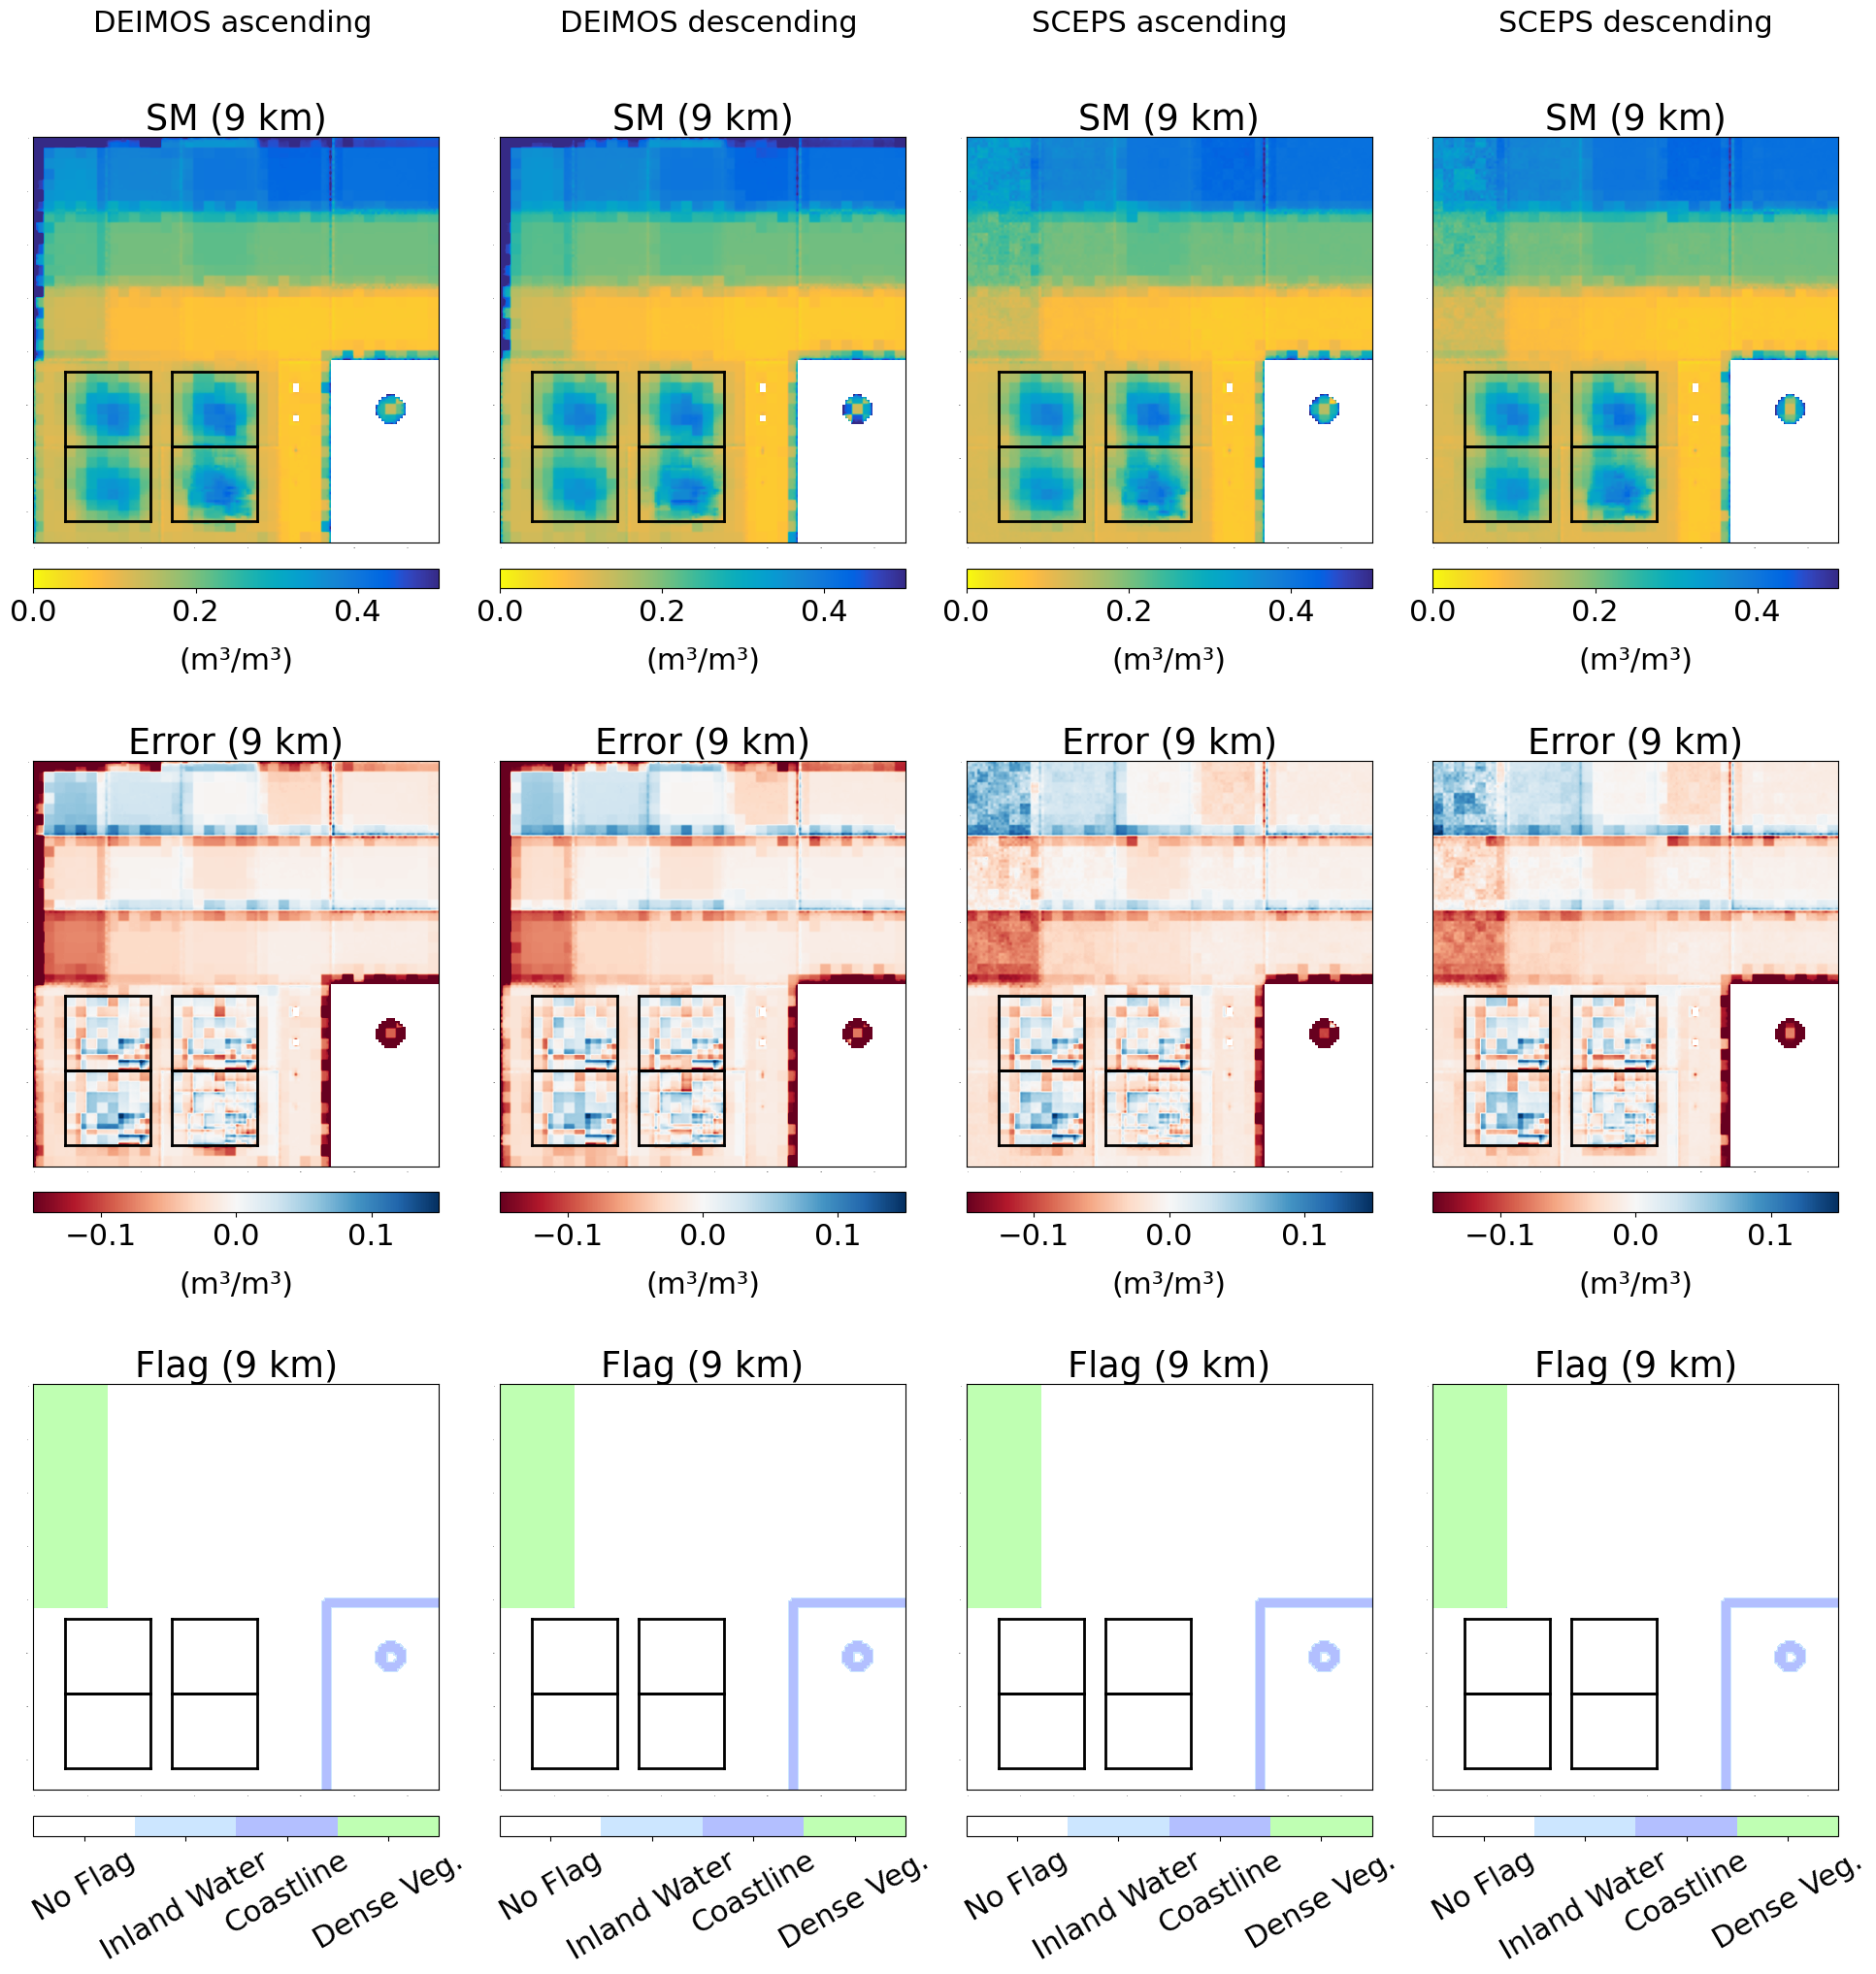

In [50]:
reload(sm_eval)

# 9 km
xdist = -0.5
ydist = -0.85
reference = tc_09['Soil Moisture'][:152, :152]
deimos_asc = l2_09_deimos_asc
deimos_des = l2_09_deimos_des
sceps_asc = l2_09_sceps_asc
sceps_des = l2_09_sceps_des
plot_range = [0, 0.5]
plot_range_diff = [-0.15, 0.15]
plt_range_flags = [0, 4]
grid = 9

# Plot
gs = gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1, 1])
fig = plt.figure(figsize=(6*4, 8*4))
# SM
ax = fig.add_subplot(gs[0, 0])
sm_eval.plot_sm(deimos_asc['soil_moisture'].data[0, :, :], 'SM (9 km)', grid, plot_range)
plt.text(22, -40, filenames[0])
ax = fig.add_subplot(gs[0, 1])
sm_eval.plot_sm(deimos_des['soil_moisture'].data[0, :, :], 'SM (9 km)', grid, plot_range)
plt.text(22, -40, filenames[1])
ax = fig.add_subplot(gs[0, 2])
sm_eval.plot_sm(sceps_asc['soil_moisture'].data[0, :, :], 'SM (9 km)', grid, plot_range)
plt.text(24, -40, filenames[2])
ax = fig.add_subplot(gs[0, 3])
sm_eval.plot_sm(sceps_des['soil_moisture'].data[0, :, :], 'SM (9 km)', grid, plot_range)
plt.text(24, -40, filenames[3])
# DELTA
ax = fig.add_subplot(gs[1, 0])
sm_eval.plot_sm_diff(reference, deimos_asc['soil_moisture'].data[0, :, :], 'Error (9 km)', grid, plot_range_diff, 'RdBu')
ax = fig.add_subplot(gs[1, 1])
sm_eval.plot_sm_diff(reference, deimos_des['soil_moisture'].data[0, :, :], 'Error (9 km)', grid, plot_range_diff, 'RdBu')
ax = fig.add_subplot(gs[1, 2])
sm_eval.plot_sm_diff(reference, sceps_asc['soil_moisture'].data[0, :, :], 'Error (9 km)', grid, plot_range_diff, 'RdBu')
ax = fig.add_subplot(gs[1, 3])
sm_eval.plot_sm_diff(reference, sceps_des['soil_moisture'].data[0, :, :], 'Error (9 km)', grid, plot_range_diff, 'RdBu')
# Flags
ax = fig.add_subplot(gs[2, 0])
sm_eval.plot_flag(deimos_asc['retrieval_scene_flag'].data[0, :, :], deimos_asc['retrieval_status_flag'].data[0, :, :], 'Flag (9 km)', grid)
ax = fig.add_subplot(gs[2, 1])
sm_eval.plot_flag(deimos_des['retrieval_scene_flag'].data[0, :, :], deimos_des['retrieval_status_flag'].data[0, :, :], 'Flag (9 km)', grid)
ax = fig.add_subplot(gs[2, 2])
sm_eval.plot_flag(sceps_asc['retrieval_scene_flag'].data[0, :, :], sceps_asc['retrieval_status_flag'].data[0, :, :], 'Flag (9 km)', grid)
ax = fig.add_subplot(gs[2, 3])
sm_eval.plot_flag(sceps_des['retrieval_scene_flag'].data[0, :, :], sceps_des['retrieval_status_flag'].data[0, :, :], 'Flag (9 km)', grid)
# adjust
plt.subplots_adjust(wspace=0.15, hspace=0.2)

### 2.3. Detailed assessment of 9 km retrievals

A more detailed view of the 9 km retrievals is given below. We compare the soil moisture reference at 9 km grid (left row) with L2 retrievals at the 36 km (middle row) and 9 km (right row) grids. This aims to illustrate the added value of 9 km retrievals compared to 36 km retrievals, assuming reference soil moisture patterns at 9 km resolution. 

- 9 km retrievals generally improve the representation of soil moisture patterns at the 9 km scale (compared to retrievals at 36 km), as expected.
- The improvement is particularly pronounced for bare soil (bottom right AOI) and grassland (top right AOI). This is expected as the C-band signal from the soil gets increasingly masked with increasing vegetation cover.
- Note:  the synthetic test card assessed here does not show spatial land cover variability at the 9 km scale, which limits the available brightness temperature variability to be captured by the sharpening algorithm. It is expected that the added value of the sharpening would increase further for scenes that include spatial land cover heterogeneity.

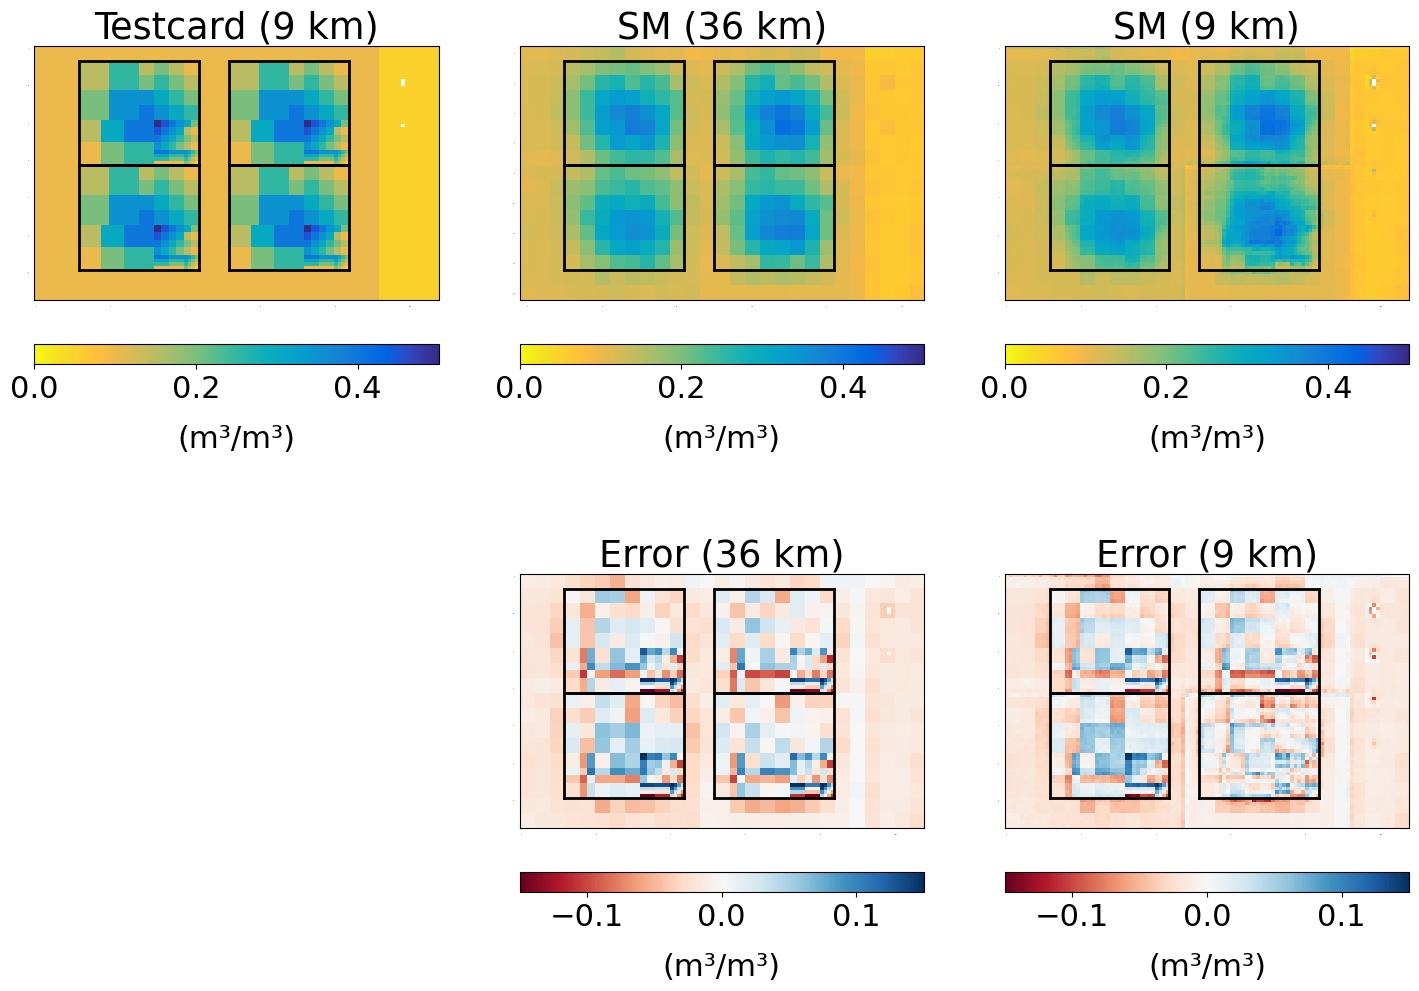

In [27]:
reload(sm_eval)

# Compare 36 km and 9 km retrievals
xdist = -0.5
ydist = -0.85
reference = tc_09['Soil Moisture'][:152, :152]
sm_09km = l2_09_sceps_des['soil_moisture'].data[0, :, :]
sm_36km = l2_36_sceps_des['soil_moisture'].data[0, :, :]
sm_36km_9km_grid = np.kron(sm_36km, np.ones((4, 4)))
plot_range = [0, 0.5]
plot_range_diff = [-0.15, 0.15]

# Plot
gs = gridspec.GridSpec(4, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1, 1])
fig = plt.figure(figsize=(6*4, 8*4))
# TB
ax = fig.add_subplot(gs[0, 0])
sm_eval.plot_tc(reference, 'Testcard', 9, plot_range, None, zoom=True)
ax = fig.add_subplot(gs[0, 1])
sm_eval.plot_sm(sm_36km, 'SM (36 km)', 36, plot_range, None, zoom=True)
ax = fig.add_subplot(gs[0, 2])
sm_eval.plot_sm(sm_09km, 'SM (9 km)', 9, plot_range, None, zoom=True)
# DELTA
ax = fig.add_subplot(gs[1, 1])
sm_eval.plot_sm_diff(reference, sm_36km_9km_grid, 'Error (36 km)', 9, plot_range_diff, 'RdBu', zoom=True)
ax = fig.add_subplot(gs[1, 2])
sm_eval.plot_sm_diff(reference, sm_09km, 'Error (9 km)', 9, plot_range_diff, 'RdBu', zoom=True)
# adjust
plt.subplots_adjust(wspace=0.2, hspace=-0.4)


### 2.4. ubRMSE and bias

We calculate the unbiased root mean square error (ubRMSE) and bias for four AOIs, which are indicated as black boxes in all previous figures. 
- The AOIs correspond to land use classes of bare soil, grassland, cropland, and mixed land use (counterclockwise, starting from the bottom right). 
- These classes correspond to vegetation water content (VWC) values of 0 kg/m², 0.2 kg/m², 2.0 kg/m², 4.6 kg/m², respectively. 
- Forest regions show a vegetation water content of 11.7 kg/m² and are not considered in the evaluation. 
- Note: In addition to different vegetation cover conditions, the land use classes also represent different vegetation structure conditions.

We calculate the ubRMSE and bias for the 36 km and 9 km retrievals. The soil moisture retrievals are compared to the test card soil moisture fields, which serve as reference. For a fair comparison, the soil moisture reference is gridded to the same scale as the corresponding L2 product.  

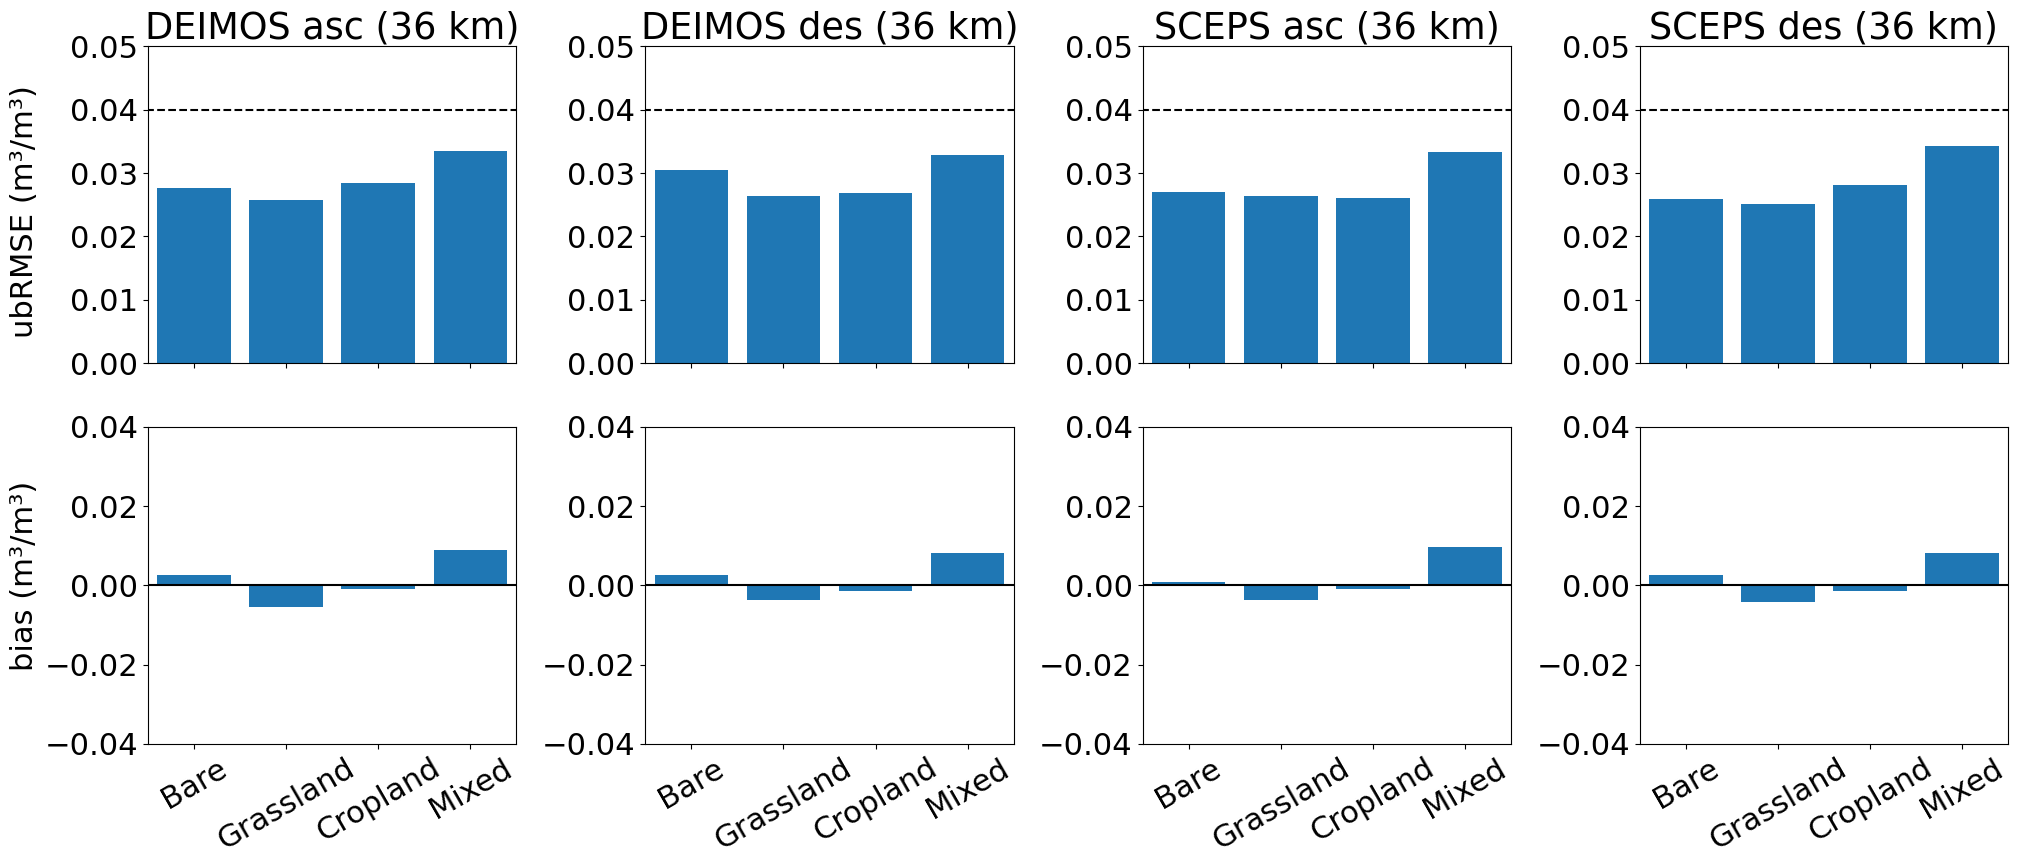

In [28]:
reload(sm_eval)

# Metrics for 36 km retrievals
reference = tc_36['Soil Moisture']
deimos_asc = l2_36_deimos_asc['soil_moisture'].data[0, :, :]
deimos_des = l2_36_deimos_des['soil_moisture'].data[0, :, :]
sceps_asc = l2_36_sceps_asc['soil_moisture'].data[0, :, :]
sceps_des = l2_36_sceps_des['soil_moisture'].data[0, :, :]
grid = 36

# Plot
gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1])
fig = plt.figure(figsize=(24, 14))
# ubRMSE
label = 'ubRMSE (m³/m³)'
ylimit = [0, 0.05]
yline = 0.04
linestyle = 'k--'
title = True
ticks = False
ax = fig.add_subplot(gs[0, 0])
sm_eval.barplot(sm_eval.ubrmserr_aoi(reference, deimos_asc,grid), ylimit, yline, linestyle, 'DEIMOS asc (36 km)', title, ticks)
plt.text(-2, 0.005, 'ubRMSE (m³/m³)', rotation=90)
ax = fig.add_subplot(gs[0, 1])
sm_eval.barplot(sm_eval.ubrmserr_aoi(reference, deimos_des,grid), ylimit, yline, linestyle, 'DEIMOS des (36 km)', title, ticks)
ax = fig.add_subplot(gs[0, 2])
sm_eval.barplot(sm_eval.ubrmserr_aoi(reference, sceps_asc,grid), ylimit, yline, linestyle, 'SCEPS asc (36 km)', title, ticks)
ax = fig.add_subplot(gs[0, 3])
sm_eval.barplot(sm_eval.ubrmserr_aoi(reference, sceps_des,grid), ylimit, yline, linestyle, 'SCEPS des (36 km)', title, ticks)
# Bias
label = 'Bias (m³/m³)'
ylimit = [-0.04, 0.04]
yline = 0.0
linestyle = 'k-'
title = False
ticks = True
ax = fig.add_subplot(gs[1, 0])
sm_eval.barplot(sm_eval.bias_aoi(reference, deimos_asc,grid), ylimit, yline, linestyle, 'DEIMOS asc', title, ticks)
plt.text(-2, -0.02, 'bias (m³/m³)', rotation=90)
ax = fig.add_subplot(gs[1, 1])
sm_eval.barplot(sm_eval.bias_aoi(reference, deimos_des,grid), ylimit, yline, linestyle, 'DEIMOS des', title, ticks)
ax = fig.add_subplot(gs[1, 2])
sm_eval.barplot(sm_eval.bias_aoi(reference, sceps_asc,grid), ylimit, yline, linestyle, 'DEIMOS asc', title, ticks)
ax = fig.add_subplot(gs[1, 3])
sm_eval.barplot(sm_eval.bias_aoi(reference, sceps_des,grid), ylimit, yline, linestyle, 'DEIMOS asc', title, ticks)
# adjust
plt.subplots_adjust(wspace=0.35, hspace=0.2)


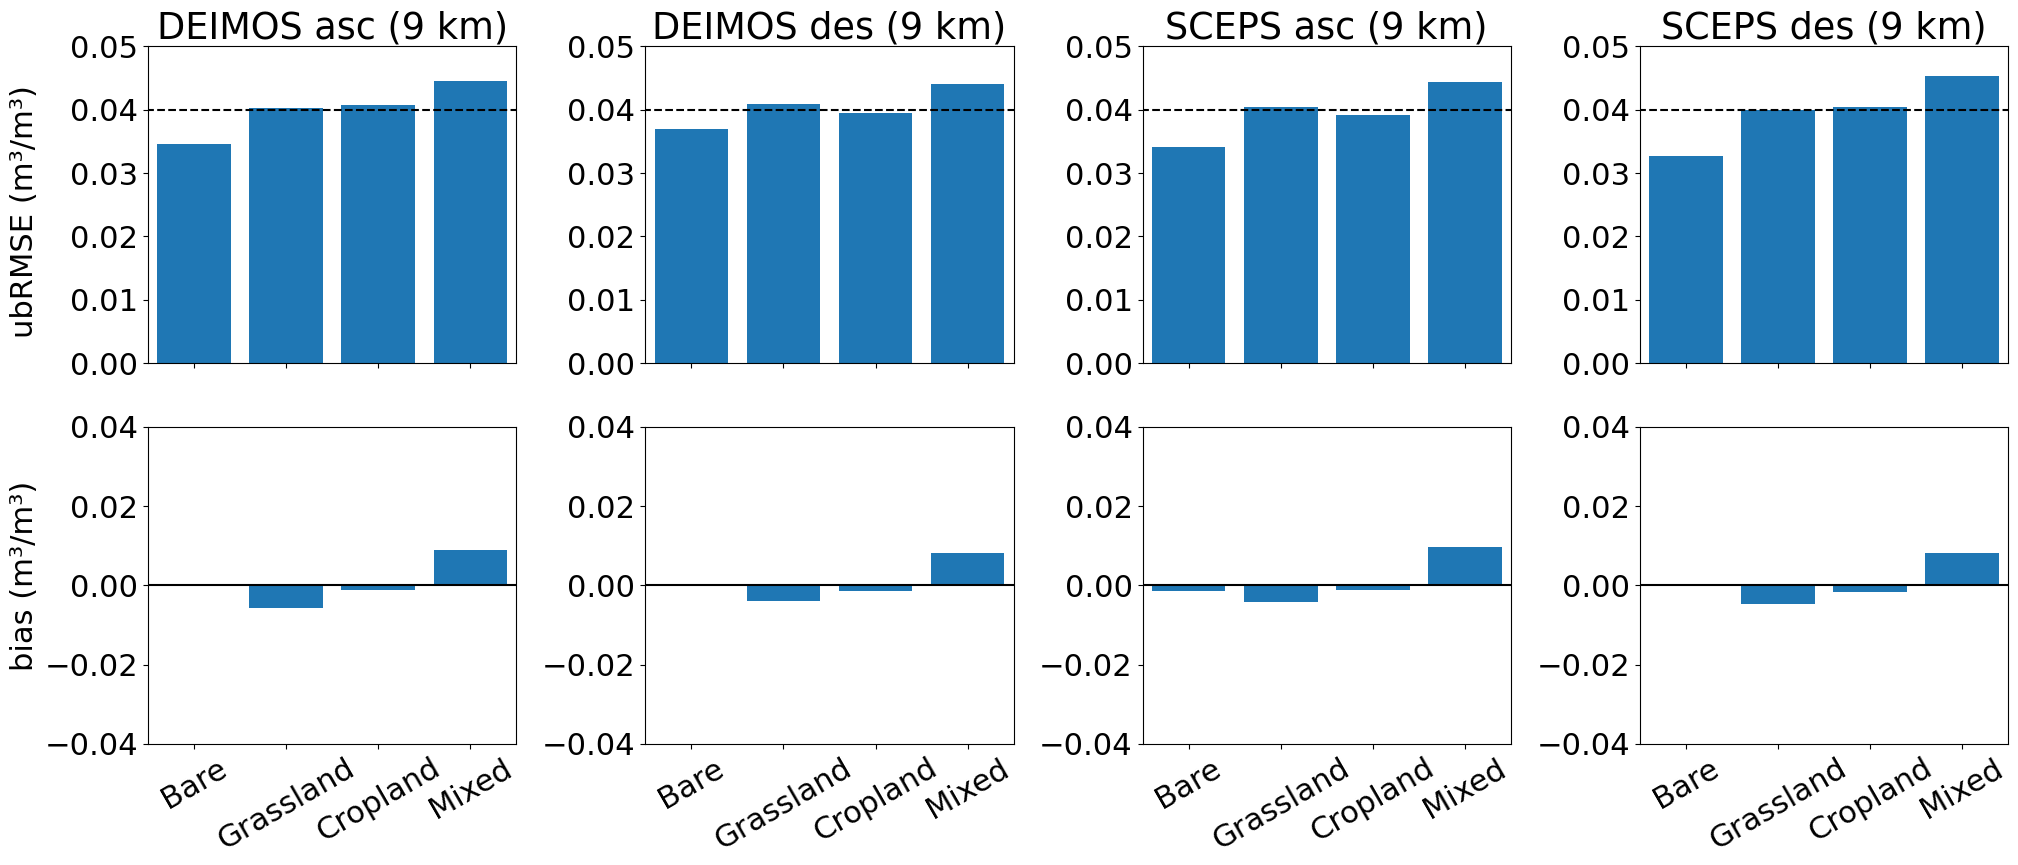

In [29]:
reload(sm_eval)

# Metrics for 9 km retrievals
reference = tc_09['Soil Moisture'][:152, :152]
deimos_asc = l2_09_deimos_asc['soil_moisture'].data[0, :, :]
deimos_des = l2_09_deimos_des['soil_moisture'].data[0, :, :]
sceps_asc = l2_09_sceps_asc['soil_moisture'].data[0, :, :]
sceps_des = l2_09_sceps_des['soil_moisture'].data[0, :, :]
grid = 9

# Plot
gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1])
fig = plt.figure(figsize=(24, 14))
# ubRMSE
label = 'ubRMSE (m³/m³)'
ylimit = [0, 0.05]
yline = 0.04
linestyle = 'k--'
title = True
ticks = False
ax = fig.add_subplot(gs[0, 0])
sm_eval.barplot(sm_eval.ubrmserr_aoi(reference, deimos_asc, grid), ylimit, yline, linestyle, 'DEIMOS asc (9 km)', title, ticks)
plt.text(-2, 0.005, 'ubRMSE (m³/m³)', rotation=90)
ax = fig.add_subplot(gs[0, 1])
sm_eval.barplot(sm_eval.ubrmserr_aoi(reference, deimos_des, grid), ylimit, yline, linestyle, 'DEIMOS des (9 km)', title, ticks)
ax = fig.add_subplot(gs[0, 2])
sm_eval.barplot(sm_eval.ubrmserr_aoi(reference, sceps_asc, grid), ylimit, yline, linestyle, 'SCEPS asc (9 km)', title, ticks)
ax = fig.add_subplot(gs[0, 3])
sm_eval.barplot(sm_eval.ubrmserr_aoi(reference, sceps_des, grid), ylimit, yline, linestyle, 'SCEPS des (9 km)', title, ticks)
# Bias
label = 'Bias (m³/m³)'
ylimit = [-0.04, 0.04]
yline = 0.0
linestyle = 'k-'
title = False
ticks = True
ax = fig.add_subplot(gs[1, 0])
sm_eval.barplot(sm_eval.bias_aoi(reference, deimos_asc, grid), ylimit, yline, linestyle, 'DEIMOS asc', title, ticks)
plt.text(-2, -0.02, 'bias (m³/m³)', rotation=90)
ax = fig.add_subplot(gs[1, 1])
sm_eval.barplot(sm_eval.bias_aoi(reference, deimos_des, grid), ylimit, yline, linestyle, 'DEIMOS des', title, ticks)
ax = fig.add_subplot(gs[1, 2])
sm_eval.barplot(sm_eval.bias_aoi(reference, sceps_asc, grid), ylimit, yline, linestyle, 'DEIMOS asc', title, ticks)
ax = fig.add_subplot(gs[1, 3])
sm_eval.barplot(sm_eval.bias_aoi(reference, sceps_des, grid), ylimit, yline, linestyle, 'DEIMOS asc', title, ticks)
# adjust
plt.subplots_adjust(wspace=0.35, hspace=0.2)


## Summary and Observations

We present a performance evaluation of a prototype L2 soil moisture retrieval algorithm for CIMR. The algorithm parameters (omega, h, tau_ini) have not been calibrated prior to the evaluation. All parameters are based on the initial proposal in [Baseline Algorithm Definition](https://cimr-algos.github.io/SoilMoisture_ATBD/baseline_algorithm_definition.html#baseline-algorithm-definition).

Observations:
- At the 36 km scale, the algorithm shows an ubRMSE < 0.04 m³/m³.
- At the 9 km scale, the algorithm shows an ubRMSE between 0.035-0.045 m³/m³.
- Errors generally increase with increasing vegetation cover, in accordance with expectations.
- Biases are overall low, and the results are consistent across  overpasses.
